### Decision Tree

In [1]:
import optuna
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
# 데이터 불러오기

per = 1

train_data = pd.read_csv("/home/watercar99/project/MIMIC-III/Data/FINAL/FINAL_Split/Final_train_data("+str(per)+"%)_down.csv")
test_data = pd.read_csv("/home/watercar99/project/MIMIC-III/Data/FINAL/FINAL_Split/Final_test_data("+str(per)+"%)_down.csv")

train_data.drop(["SUBJECT_ID","HADM_ID", "DOA", "ETHNICITY"], axis=1, inplace=True)
test_data.drop(["SUBJECT_ID","HADM_ID", "DOA",  "ETHNICITY"], axis=1, inplace=True)
                
train_data = pd.get_dummies(train_data, columns=['GENDER', 'Ventilator', 'Anisocytosis', 'Macrocytes', 'Poikilocytosis', 'Bacteria', 'Bilirubin', 'Urine Appearance', 'Urine Color'])
test_data = pd.get_dummies(test_data, columns=['GENDER', 'Ventilator', 'Anisocytosis', 'Macrocytes', 'Poikilocytosis', 'Bacteria', 'Bilirubin', 'Urine Appearance', 'Urine Color'])

In [3]:
# train_data와 test_data의 칼럼을 맞추기 위해 차집합을 계산
missing_columns_in_test = set(train_data.columns) - set(test_data.columns)
missing_columns_in_train = set(test_data.columns) - set(train_data.columns)

# test_data에 train_data의 더미 변수를 추가하고 0으로 채워주기
for col in missing_columns_in_test:
    test_data[col] = 0

# train_data에 test_data의 더미 변수를 추가하고 0으로 채워주기
for col in missing_columns_in_train:
    train_data[col] = 0

# Features와 Target 설정
X_train = train_data.drop('y', axis=1)
y_train = train_data['y']
X_test = test_data.drop('y', axis=1)

print("train shape\n",X_train.shape,"\n")
print("train shape\n",X_test.shape,"\n")

target = "y"
features = [f for f in train_data.columns if f not in [target]]

print("train value\n",train_data['y'].value_counts())
print("test value\n",test_data['y'].value_counts())

train shape
 (978, 100) 

train shape
 (457, 100) 

train value
 1    489
0    489
Name: y, dtype: int64
test value
 0    341
1    116
Name: y, dtype: int64


In [4]:
# Objective 함수 정의
def objective(trial):
    max_depth = trial.suggest_int("max_depth", 2, 10)
    min_samples_split = trial.suggest_float("min_samples_split", 0.1, 1.0)
    min_samples_leaf = trial.suggest_float("min_samples_leaf", 0.1, 0.5)
    
    model = DecisionTreeClassifier(
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )
    
    # Cross Validation을 활용한 평가 지표 계산
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring="f1")
    return scores.mean()

In [5]:
from sklearn.metrics import roc_auc_score

accuracy_list = []
precision_list = []
recall_list = []
f1_list = []
y_pred_list = []
model_list = []
auroc_list = []

for _ in range(10):

    # Optuna를 활용한 Hyperparameter tuning
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=30, show_progress_bar=True)

    # 최적의 Hyperparameter로 모델 학습
    best_params = study.best_params
    best_model = DecisionTreeClassifier(
        max_depth=best_params["max_depth"],
        min_samples_split=best_params["min_samples_split"],
        min_samples_leaf=best_params["min_samples_leaf"],
        random_state=42
    )
    best_model.fit(X_train, y_train)
    
    # Test 데이터로 모델 평가
    y_pred = best_model.predict(X_test)
    accuracy = accuracy_score(test_data['y'], y_pred)
    precision = precision_score(test_data['y'], y_pred)
    recall = recall_score(test_data['y'], y_pred)
    f1 = f1_score(test_data['y'], y_pred)
    auroc = roc_auc_score(test_data['y'], y_pred)

    rounded_accuracy = round(accuracy * 100, 2)
    rounded_precision = round(precision * 100, 2)
    rounded_recall = round(recall * 100, 2)
    rounded_f1 = round(f1 * 100, 2)
    rounded_auroc = round(auroc * 100, 2)
    
    accuracy_list.append(rounded_accuracy)
    precision_list.append(rounded_precision)
    recall_list.append(rounded_recall)
    f1_list.append(rounded_f1)
    y_pred_list.append(y_pred)
    auroc_list.append(rounded_auroc)
    
    print("Test Accuracy:", rounded_accuracy)
    print("Precision:", rounded_precision)
    print("Recall:", rounded_recall)
    print("F1-score:", rounded_f1)
    print("AUROC:", rounded_auroc)

[I 2023-10-05 22:38:21,796] A new study created in memory with name: no-name-1137477c-e171-4936-a210-4cce6d4a850f


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2023-10-05 22:38:21,866] Trial 0 finished with value: 0.5762044398681251 and parameters: {'max_depth': 3, 'min_samples_split': 0.9039791213087237, 'min_samples_leaf': 0.3388904097781721}. Best is trial 0 with value: 0.5762044398681251.
[I 2023-10-05 22:38:21,905] Trial 1 finished with value: 0.5788870505632289 and parameters: {'max_depth': 10, 'min_samples_split': 0.44003216533529366, 'min_samples_leaf': 0.4146720760795547}. Best is trial 1 with value: 0.5788870505632289.
[I 2023-10-05 22:38:21,961] Trial 2 finished with value: 0.5970354967841452 and parameters: {'max_depth': 3, 'min_samples_split': 0.38480521240974896, 'min_samples_leaf': 0.47034878366287225}. Best is trial 2 with value: 0.5970354967841452.
[I 2023-10-05 22:38:21,998] Trial 3 finished with value: 0.580965397940465 and parameters: {'max_depth': 6, 'min_samples_split': 0.11789096589680943, 'min_samples_leaf': 0.4265524190015376}. Best is trial 2 with value: 0.5970354967841452.
[I 2023-10-05 22:38:22,036] Trial 4 fini

[I 2023-10-05 22:38:23,453] A new study created in memory with name: no-name-5647ae6e-c0cf-4505-99a4-2deb90e804f6


[I 2023-10-05 22:38:23,348] Trial 28 finished with value: 0.6958831433605701 and parameters: {'max_depth': 5, 'min_samples_split': 0.535454561806582, 'min_samples_leaf': 0.30095718278357647}. Best is trial 25 with value: 0.6960798079294814.
[I 2023-10-05 22:38:23,432] Trial 29 finished with value: 0.6958831433605701 and parameters: {'max_depth': 5, 'min_samples_split': 0.3628560210217098, 'min_samples_leaf': 0.30265188181171443}. Best is trial 25 with value: 0.6960798079294814.
Test Accuracy: 56.02
Precision: 32.93
Recall: 70.69
F1-score: 44.93
AUROC: 60.86


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2023-10-05 22:38:23,517] Trial 0 finished with value: 0.6874300738598168 and parameters: {'max_depth': 5, 'min_samples_split': 0.30557791871912815, 'min_samples_leaf': 0.20769288399208197}. Best is trial 0 with value: 0.6874300738598168.
[I 2023-10-05 22:38:23,553] Trial 1 finished with value: 0.584391574371049 and parameters: {'max_depth': 10, 'min_samples_split': 0.5352637026691349, 'min_samples_leaf': 0.36092680763053153}. Best is trial 0 with value: 0.6874300738598168.
[I 2023-10-05 22:38:23,592] Trial 2 finished with value: 0.5797801761743611 and parameters: {'max_depth': 2, 'min_samples_split': 0.9620175925878026, 'min_samples_leaf': 0.441063606483717}. Best is trial 0 with value: 0.6874300738598168.
[I 2023-10-05 22:38:23,628] Trial 3 finished with value: 0.584391574371049 and parameters: {'max_depth': 3, 'min_samples_split': 0.9931068325675649, 'min_samples_leaf': 0.3610341300111207}. Best is trial 0 with value: 0.6874300738598168.
[I 2023-10-05 22:38:23,673] Trial 4 finishe

[I 2023-10-05 22:38:25,042] A new study created in memory with name: no-name-387cd9a2-2060-40f1-b87f-83b2f4a9afda


[I 2023-10-05 22:38:24,937] Trial 27 finished with value: 0.6958831433605701 and parameters: {'max_depth': 8, 'min_samples_split': 0.42788263475386873, 'min_samples_leaf': 0.29990232251370197}. Best is trial 22 with value: 0.7022930408876256.
[I 2023-10-05 22:38:24,982] Trial 28 finished with value: 0.5797801761743611 and parameters: {'max_depth': 9, 'min_samples_split': 0.6049486025540587, 'min_samples_leaf': 0.4380992940092763}. Best is trial 22 with value: 0.7022930408876256.
[I 2023-10-05 22:38:25,028] Trial 29 finished with value: 0.5762044398681251 and parameters: {'max_depth': 6, 'min_samples_split': 0.5120720110244718, 'min_samples_leaf': 0.3355977304317162}. Best is trial 22 with value: 0.7022930408876256.
Test Accuracy: 52.08
Precision: 31.27
Recall: 74.14
F1-score: 43.99
AUROC: 59.36


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2023-10-05 22:38:25,113] Trial 0 finished with value: 0.5879995194571959 and parameters: {'max_depth': 5, 'min_samples_split': 0.715961066155875, 'min_samples_leaf': 0.4874398264599006}. Best is trial 0 with value: 0.5879995194571959.
[I 2023-10-05 22:38:25,153] Trial 1 finished with value: 0.5490889240673335 and parameters: {'max_depth': 3, 'min_samples_split': 0.8906055577921925, 'min_samples_leaf': 0.2607638662030479}. Best is trial 0 with value: 0.5879995194571959.
[I 2023-10-05 22:38:25,208] Trial 2 finished with value: 0.6941559188581098 and parameters: {'max_depth': 3, 'min_samples_split': 0.5423724575804861, 'min_samples_leaf': 0.25567898487392327}. Best is trial 2 with value: 0.6941559188581098.
[I 2023-10-05 22:38:25,254] Trial 3 finished with value: 0.5490889240673335 and parameters: {'max_depth': 6, 'min_samples_split': 0.920929986432528, 'min_samples_leaf': 0.22271519668461034}. Best is trial 2 with value: 0.6941559188581098.
[I 2023-10-05 22:38:25,300] Trial 4 finished

[I 2023-10-05 22:38:26,575] A new study created in memory with name: no-name-c193c63a-f64d-4078-a146-7e507f287cf7


[I 2023-10-05 22:38:26,470] Trial 27 finished with value: 0.5490889240673335 and parameters: {'max_depth': 2, 'min_samples_split': 0.7880238419923319, 'min_samples_leaf': 0.2809764442503737}. Best is trial 14 with value: 0.6996037439718117.
[I 2023-10-05 22:38:26,518] Trial 28 finished with value: 0.584391574371049 and parameters: {'max_depth': 4, 'min_samples_split': 0.5093057686019378, 'min_samples_leaf': 0.37333081524957523}. Best is trial 14 with value: 0.6996037439718117.
[I 2023-10-05 22:38:26,561] Trial 29 finished with value: 0.5806546997658167 and parameters: {'max_depth': 3, 'min_samples_split': 0.743084246571131, 'min_samples_leaf': 0.453414273980645}. Best is trial 14 with value: 0.6996037439718117.
Test Accuracy: 52.08
Precision: 31.27
Recall: 74.14
F1-score: 43.99
AUROC: 59.36


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2023-10-05 22:38:26,643] Trial 0 finished with value: 0.5837557381609728 and parameters: {'max_depth': 6, 'min_samples_split': 0.6561525034814786, 'min_samples_leaf': 0.4663601731036794}. Best is trial 0 with value: 0.5837557381609728.
[I 2023-10-05 22:38:26,707] Trial 1 finished with value: 0.6772664044316496 and parameters: {'max_depth': 9, 'min_samples_split': 0.3680545988999795, 'min_samples_leaf': 0.11864677682554406}. Best is trial 1 with value: 0.6772664044316496.
[I 2023-10-05 22:38:26,762] Trial 2 finished with value: 0.5490889240673335 and parameters: {'max_depth': 8, 'min_samples_split': 0.8059943309120744, 'min_samples_leaf': 0.2676131732753675}. Best is trial 1 with value: 0.6772664044316496.
[I 2023-10-05 22:38:26,821] Trial 3 finished with value: 0.691094365522628 and parameters: {'max_depth': 8, 'min_samples_split': 0.12893200797810436, 'min_samples_leaf': 0.231322131285297}. Best is trial 3 with value: 0.691094365522628.
[I 2023-10-05 22:38:26,884] Trial 4 finished 

[I 2023-10-05 22:38:28,225] A new study created in memory with name: no-name-a514eadb-3aad-43d6-8342-2836a371081f


Test Accuracy: 51.2
Precision: 31.1
Recall: 75.86
F1-score: 44.11
AUROC: 59.34


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2023-10-05 22:38:28,288] Trial 0 finished with value: 0.5490889240673335 and parameters: {'max_depth': 8, 'min_samples_split': 0.9603714487931281, 'min_samples_leaf': 0.22655545446738096}. Best is trial 0 with value: 0.5490889240673335.
[I 2023-10-05 22:38:28,320] Trial 1 finished with value: 0.584391574371049 and parameters: {'max_depth': 2, 'min_samples_split': 0.8292994183669711, 'min_samples_leaf': 0.34147747770761777}. Best is trial 1 with value: 0.584391574371049.
[I 2023-10-05 22:38:28,360] Trial 2 finished with value: 0.691094365522628 and parameters: {'max_depth': 6, 'min_samples_split': 0.2079074241027713, 'min_samples_leaf': 0.23264646837138747}. Best is trial 2 with value: 0.691094365522628.
[I 2023-10-05 22:38:28,402] Trial 3 finished with value: 0.6772664044316496 and parameters: {'max_depth': 8, 'min_samples_split': 0.605095821098356, 'min_samples_leaf': 0.145233475325393}. Best is trial 2 with value: 0.691094365522628.
[I 2023-10-05 22:38:28,444] Trial 4 finished wit

[I 2023-10-05 22:38:29,915] A new study created in memory with name: no-name-483b6f46-d265-4a9d-b40d-eca53de126fe


[I 2023-10-05 22:38:29,835] Trial 28 finished with value: 0.584391574371049 and parameters: {'max_depth': 5, 'min_samples_split': 0.6740761303931618, 'min_samples_leaf': 0.36911344608756247}. Best is trial 21 with value: 0.7016562849913498.
[I 2023-10-05 22:38:29,894] Trial 29 finished with value: 0.7016562849913498 and parameters: {'max_depth': 3, 'min_samples_split': 0.5502164203141511, 'min_samples_leaf': 0.31818209313051454}. Best is trial 21 with value: 0.7016562849913498.
Test Accuracy: 52.08
Precision: 31.27
Recall: 74.14
F1-score: 43.99
AUROC: 59.36


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2023-10-05 22:38:30,000] Trial 0 finished with value: 0.5490889240673335 and parameters: {'max_depth': 2, 'min_samples_split': 0.8727327065387647, 'min_samples_leaf': 0.20291568605643714}. Best is trial 0 with value: 0.5490889240673335.
[I 2023-10-05 22:38:30,038] Trial 1 finished with value: 0.584391574371049 and parameters: {'max_depth': 2, 'min_samples_split': 0.9468894375748714, 'min_samples_leaf': 0.34589496239863987}. Best is trial 1 with value: 0.584391574371049.
[I 2023-10-05 22:38:30,080] Trial 2 finished with value: 0.5797660815511708 and parameters: {'max_depth': 8, 'min_samples_split': 0.7223597525844594, 'min_samples_leaf': 0.4091312815146724}. Best is trial 1 with value: 0.584391574371049.
[I 2023-10-05 22:38:30,118] Trial 3 finished with value: 0.5811506599901902 and parameters: {'max_depth': 3, 'min_samples_split': 0.2102127624328049, 'min_samples_leaf': 0.4011370430547673}. Best is trial 1 with value: 0.584391574371049.
[I 2023-10-05 22:38:30,171] Trial 4 finished w

[I 2023-10-05 22:38:31,622] A new study created in memory with name: no-name-c99fef89-de05-4d2f-88cb-95e297ac25b9


[I 2023-10-05 22:38:31,465] Trial 27 finished with value: 0.6958831433605701 and parameters: {'max_depth': 3, 'min_samples_split': 0.17620901425481356, 'min_samples_leaf': 0.29845681040018474}. Best is trial 14 with value: 0.7022309976350279.
[I 2023-10-05 22:38:31,537] Trial 28 finished with value: 0.584391574371049 and parameters: {'max_depth': 5, 'min_samples_split': 0.2731430375624812, 'min_samples_leaf': 0.3680559631108124}. Best is trial 14 with value: 0.7022309976350279.
[I 2023-10-05 22:38:31,592] Trial 29 finished with value: 0.6772664044316496 and parameters: {'max_depth': 2, 'min_samples_split': 0.6044746681718641, 'min_samples_leaf': 0.17113605606723642}. Best is trial 14 with value: 0.7022309976350279.
Test Accuracy: 51.42
Precision: 31.21
Recall: 75.86
F1-score: 44.22
AUROC: 59.49


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2023-10-05 22:38:31,692] Trial 0 finished with value: 0.5490889240673335 and parameters: {'max_depth': 9, 'min_samples_split': 0.7676723457585413, 'min_samples_leaf': 0.20157946008783723}. Best is trial 0 with value: 0.5490889240673335.
[I 2023-10-05 22:38:31,741] Trial 1 finished with value: 0.691094365522628 and parameters: {'max_depth': 8, 'min_samples_split': 0.34510849307864344, 'min_samples_leaf': 0.23444153545388133}. Best is trial 1 with value: 0.691094365522628.
[I 2023-10-05 22:38:31,782] Trial 2 finished with value: 0.5806546997658167 and parameters: {'max_depth': 8, 'min_samples_split': 0.8627276949739419, 'min_samples_leaf': 0.4495773770087562}. Best is trial 1 with value: 0.691094365522628.
[I 2023-10-05 22:38:31,820] Trial 3 finished with value: 0.5490889240673335 and parameters: {'max_depth': 10, 'min_samples_split': 0.9657214392388425, 'min_samples_leaf': 0.18486557632198175}. Best is trial 1 with value: 0.691094365522628.
[I 2023-10-05 22:38:31,883] Trial 4 finishe

[I 2023-10-05 22:38:33,214] A new study created in memory with name: no-name-01f009df-b532-4be4-a5f4-a6d1a793cdb0


[I 2023-10-05 22:38:33,041] Trial 26 finished with value: 0.6941559188581098 and parameters: {'max_depth': 9, 'min_samples_split': 0.2397731412365373, 'min_samples_leaf': 0.24749611482954137}. Best is trial 20 with value: 0.7017920093521114.
[I 2023-10-05 22:38:33,096] Trial 27 finished with value: 0.6993273966411964 and parameters: {'max_depth': 7, 'min_samples_split': 0.6388545487022095, 'min_samples_leaf': 0.3234206855301851}. Best is trial 20 with value: 0.7017920093521114.
[I 2023-10-05 22:38:33,140] Trial 28 finished with value: 0.5797660815511708 and parameters: {'max_depth': 8, 'min_samples_split': 0.45847501274200814, 'min_samples_leaf': 0.4087895796469848}. Best is trial 20 with value: 0.7017920093521114.
[I 2023-10-05 22:38:33,186] Trial 29 finished with value: 0.5490889240673335 and parameters: {'max_depth': 10, 'min_samples_split': 0.7677543580377458, 'min_samples_leaf': 0.171522561407531}. Best is trial 20 with value: 0.7017920093521114.
Test Accuracy: 52.08
Precision: 31

  0%|          | 0/30 [00:00<?, ?it/s]

[I 2023-10-05 22:38:33,299] Trial 0 finished with value: 0.5824189257974981 and parameters: {'max_depth': 10, 'min_samples_split': 0.12607391879349764, 'min_samples_leaf': 0.3978866514615482}. Best is trial 0 with value: 0.5824189257974981.
[I 2023-10-05 22:38:33,340] Trial 1 finished with value: 0.5970354967841452 and parameters: {'max_depth': 2, 'min_samples_split': 0.5507238271785986, 'min_samples_leaf': 0.4730044110628765}. Best is trial 1 with value: 0.5970354967841452.
[I 2023-10-05 22:38:33,398] Trial 2 finished with value: 0.5797801761743611 and parameters: {'max_depth': 2, 'min_samples_split': 0.313774973288826, 'min_samples_leaf': 0.4368992592367923}. Best is trial 1 with value: 0.5970354967841452.
[I 2023-10-05 22:38:33,441] Trial 3 finished with value: 0.5985015407798971 and parameters: {'max_depth': 10, 'min_samples_split': 0.6840601477732536, 'min_samples_leaf': 0.16494193821588513}. Best is trial 3 with value: 0.5985015407798971.
[I 2023-10-05 22:38:33,478] Trial 4 finis

[I 2023-10-05 22:38:34,792] A new study created in memory with name: no-name-c9d31e53-5972-4f58-8c75-3232c14e50b7


[I 2023-10-05 22:38:34,682] Trial 27 finished with value: 0.5490889240673335 and parameters: {'max_depth': 8, 'min_samples_split': 0.7501927524970488, 'min_samples_leaf': 0.30128978391900174}. Best is trial 25 with value: 0.6996037439718117.
[I 2023-10-05 22:38:34,734] Trial 28 finished with value: 0.6941559188581098 and parameters: {'max_depth': 6, 'min_samples_split': 0.5616902608502569, 'min_samples_leaf': 0.23990622107778772}. Best is trial 25 with value: 0.6996037439718117.
[I 2023-10-05 22:38:34,778] Trial 29 finished with value: 0.5837289762890961 and parameters: {'max_depth': 10, 'min_samples_split': 0.6031139180797811, 'min_samples_leaf': 0.39097351455108226}. Best is trial 25 with value: 0.6996037439718117.
Test Accuracy: 52.08
Precision: 31.27
Recall: 74.14
F1-score: 43.99
AUROC: 59.36


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2023-10-05 22:38:34,844] Trial 0 finished with value: 0.5933523076855987 and parameters: {'max_depth': 6, 'min_samples_split': 0.5381475518550863, 'min_samples_leaf': 0.49651561889489815}. Best is trial 0 with value: 0.5933523076855987.
[I 2023-10-05 22:38:34,881] Trial 1 finished with value: 0.5490889240673335 and parameters: {'max_depth': 6, 'min_samples_split': 0.8433471233250324, 'min_samples_leaf': 0.24470700746770102}. Best is trial 0 with value: 0.5933523076855987.
[I 2023-10-05 22:38:34,920] Trial 2 finished with value: 0.5490889240673335 and parameters: {'max_depth': 3, 'min_samples_split': 0.8791206672634766, 'min_samples_leaf': 0.29404703497658813}. Best is trial 0 with value: 0.5933523076855987.
[I 2023-10-05 22:38:34,997] Trial 3 finished with value: 0.5490889240673335 and parameters: {'max_depth': 7, 'min_samples_split': 0.6970231536242644, 'min_samples_leaf': 0.21315037819088112}. Best is trial 0 with value: 0.5933523076855987.
[I 2023-10-05 22:38:35,038] Trial 4 fini

[I 2023-10-05 22:38:36,401] A new study created in memory with name: no-name-798f4b7d-2bb8-4601-b073-3e3d2d30aeb5


Test Accuracy: 51.2
Precision: 31.1
Recall: 75.86
F1-score: 44.11
AUROC: 59.34


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2023-10-05 22:38:36,456] Trial 0 finished with value: 0.5490889240673335 and parameters: {'max_depth': 8, 'min_samples_split': 0.6975224323517952, 'min_samples_leaf': 0.30758478427056846}. Best is trial 0 with value: 0.5490889240673335.
[I 2023-10-05 22:38:36,494] Trial 1 finished with value: 0.5762044398681251 and parameters: {'max_depth': 3, 'min_samples_split': 0.2768871334387265, 'min_samples_leaf': 0.3349529119077235}. Best is trial 1 with value: 0.5762044398681251.
[I 2023-10-05 22:38:36,534] Trial 2 finished with value: 0.584391574371049 and parameters: {'max_depth': 2, 'min_samples_split': 0.5945331772494724, 'min_samples_leaf': 0.3770122701383851}. Best is trial 2 with value: 0.584391574371049.
[I 2023-10-05 22:38:36,573] Trial 3 finished with value: 0.5806546997658167 and parameters: {'max_depth': 8, 'min_samples_split': 0.4636825534756386, 'min_samples_leaf': 0.450744536763935}. Best is trial 2 with value: 0.584391574371049.
[I 2023-10-05 22:38:36,612] Trial 4 finished wi

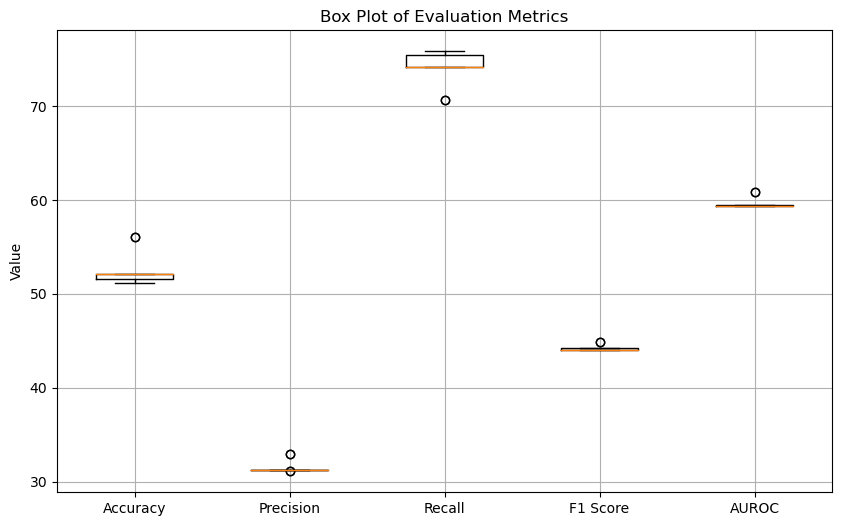

In [6]:
import matplotlib.pyplot as plt

# 박스 플롯 그리기
data = [accuracy_list, precision_list, recall_list, f1_list, auroc_list]
labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score','AUROC']

plt.figure(figsize=(10, 6))
plt.boxplot(data, labels=labels)
plt.title('Box Plot of Evaluation Metrics')
plt.ylabel('Value')
plt.grid(True)
plt.show()

In [7]:
data = {
    'Accuracy': accuracy_list,
    'Precision': precision_list,
    'Recall': recall_list,
    'F1 Score': f1_list,
    'AUROC':auroc_list,
    'Predictions': y_pred_list
    
}

# 딕셔너리를 DataFrame으로 변환
df = pd.DataFrame(data)
df

,Accuracy,Precision,Recall,F1 Score,AUROC,Predictions
0,56.02,32.93,70.69,44.93,60.86,"[1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, ..."
1,52.08,31.27,74.14,43.99,59.36,"[1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, ..."
2,52.08,31.27,74.14,43.99,59.36,"[1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, ..."
3,51.20,31.10,75.86,44.11,59.34,"[1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, ..."
4,52.08,31.27,74.14,43.99,59.36,"[1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, ..."
5,51.42,31.21,75.86,44.22,59.49,"[1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, ..."
6,52.08,31.27,74.14,43.99,59.36,"[1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, ..."
7,52.08,31.27,74.14,43.99,59.36,"[1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, ..."
8,51.20,31.10,75.86,44.11,59.34,"[1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, ..."
9,56.02,32.93,70.69,44.93,60.86,"[1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, ..."


### result

In [8]:
df.to_csv('~/project/MIMIC-III/Model/Output/FINAL/DT/DT_'+str(per)+'%_output.csv', index=False)

In [9]:
# # 그리고 싶은 confusion matrix index
# idx = 1 

# cm = confusion_matrix(test_data['y'], y_pred_list[idx])


# # Confusion Matrix 시각화
# cm_df = pd.DataFrame(cm, index=['Actual 0', 'Actual 1'], columns=['Predicted 0', 'Predicted 1'])
# plt.figure(figsize=(6, 4))
# sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
# plt.title('Confusion Matrix')
# plt.xlabel('Predicted Label')
# plt.ylabel('Actual Label')
# plt.show()

# # Classification Report 출력
# print("Classification Report:")
# print(classification_report(test_data['y'], y_pred))

# # Precision-Recall Curve 계산 및 시각화
# precision, recall, _ = precision_recall_curve(test_data['y'], best_model.predict_proba(X_test)[:, 1])
# average_precision = auc(recall, precision)
# plt.figure()
# plt.step(recall, precision, color='b', alpha=0.2, where='post')
# plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
# plt.xlabel('Recall')
# plt.ylabel('Precision')
# plt.title(f'Precision-Recall Curve (AP = {average_precision:.2f})')
# plt.show()

# # Feature Importance 계산
# feature_importance = best_model.feature_importances_

# # Feature Importance 시각화
# plt.figure(figsize=(10, 6))
# sns.barplot(x=feature_importance, y=features)
# plt.title('Feature Importance')
# plt.xlabel('Importance')
# plt.ylabel('Feature')
# plt.show()